# Vertical Federated Learning Simulation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [2]:
class DiabetesClientEmbeddingModel(nn.Module):
    """
    Embedding model for the VFL clients.
    """
    def __init__(self, input_dim, output_dim=8, hidden_dim=24):
        super(DiabetesClientEmbeddingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x
    
class DiabetesServerModel(nn.Module):
    """
    Model for the VFL server.
    """
    def __init__(self, input_dim, output_dim=1, hidden_dim=12):
        super(DiabetesServerModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Create client embedding models and server model
client1_embedding_model = DiabetesClientEmbeddingModel(input_dim=3, output_dim=8, hidden_dim=24)
client2_embedding_model = DiabetesClientEmbeddingModel(input_dim=3, output_dim=8, hidden_dim=24)
client3_embedding_model = DiabetesClientEmbeddingModel(input_dim=4, output_dim=8, hidden_dim=24)
server_model = DiabetesServerModel(input_dim=24, output_dim=1, hidden_dim=12)

In [4]:
# Prepare the training data for each client
X_train_client1 = X_train[:, :3]
X_train_client2 = X_train[:, 3:6]
X_train_client3 = X_train[:, 6:]

In [5]:
# Prepare the testing data for each client
X_test_client1 = X_test[:, :3]
X_test_client2 = X_test[:, 3:6]
X_test_client3 = X_test[:, 6:]

In [6]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer_client1 = optim.Adam(client1_embedding_model.parameters(), lr=0.01)
optimizer_client2 = optim.Adam(client2_embedding_model.parameters(), lr=0.01)
optimizer_client3 = optim.Adam(client3_embedding_model.parameters(), lr=0.01)
optimizer_server = optim.Adam(server_model.parameters(), lr=0.01)

In [7]:
num_epochs = 500
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train the client models
    client1_embedding_model.train()
    client2_embedding_model.train()
    client3_embedding_model.train()
    optimizer_client1.zero_grad()
    optimizer_client2.zero_grad()
    optimizer_client3.zero_grad()
    
    client1_embedding = client1_embedding_model(X_train_client1)
    client2_embedding = client2_embedding_model(X_train_client2)
    client3_embedding = client3_embedding_model(X_train_client3)
    
    client1_embedding_clone = client1_embedding.detach().clone()
    client2_embedding_clone = client2_embedding.detach().clone()
    client3_embedding_clone = client3_embedding.detach().clone()
    
    # Train the server model
    server_model.train()
    optimizer_server.zero_grad()
    embedding_server = torch.cat([client1_embedding_clone, client2_embedding_clone, client3_embedding_clone], dim=1)
    embedding_server = embedding_server.detach().requires_grad_()
    y_pred = server_model(embedding_server)
    loss = criterion(y_pred, y_train)
    train_losses.append(loss.item())
    loss.backward()
    optimizer_server.step()
        
    # Update the client models
    grads = embedding_server.grad.split([8, 8, 8], dim=1)
    client1_embedding.backward(grads[0])
    client2_embedding.backward(grads[1])
    client3_embedding.backward(grads[2])
    optimizer_client1.step()
    optimizer_client2.step()
    optimizer_client3.step()
    
    # Evaluate the overall model
    with torch.no_grad():
        client1_embedding_model.eval()
        client2_embedding_model.eval()
        client3_embedding_model.eval()
        server_model.eval()
        client1_embedding_val = client1_embedding_model(X_test_client1)
        client2_embedding_val = client2_embedding_model(X_test_client2)
        client3_embedding_val = client3_embedding_model(X_test_client3)
        embedding_aggregated_val = torch.cat([client1_embedding_val, client2_embedding_val, client3_embedding_val], dim=1)
        y_pred_val = server_model(embedding_aggregated_val)
        val_loss = criterion(y_pred_val, y_test)
        val_losses.append(val_loss.item())
        
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] train loss: {loss.item()} val loss: {val_loss.item()}")


Epoch [50/500] train loss: 5346.0751953125 val loss: 4225.123046875
Epoch [100/500] train loss: 2953.00537109375 val loss: 2973.92236328125
Epoch [150/500] train loss: 2803.99609375 val loss: 2819.716552734375
Epoch [200/500] train loss: 2740.162353515625 val loss: 2766.43603515625
Epoch [250/500] train loss: 2702.61865234375 val loss: 2727.213134765625
Epoch [300/500] train loss: 2674.85498046875 val loss: 2711.14208984375
Epoch [350/500] train loss: 2647.4228515625 val loss: 2715.962890625
Epoch [400/500] train loss: 2621.880615234375 val loss: 2736.22900390625
Epoch [450/500] train loss: 2597.298095703125 val loss: 2754.030517578125
Epoch [500/500] train loss: 2572.24560546875 val loss: 2762.86474609375


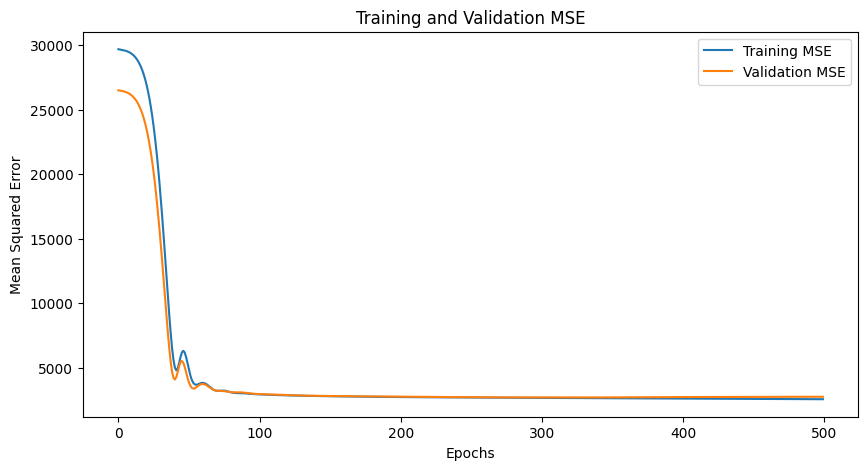

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training MSE')
plt.plot(val_losses, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')
plt.show()